In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy

import os
%matplotlib inline

In [3]:
plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42
sc.set_figure_params(dpi=100, figsize=(8,8), fontsize=20)

## Function

In [4]:
def heatmapPlot(data,
                cmap=None,
                threashold=None,
                fmt = 'd',
                minimum=0,
                figsize=(9.5,7.8),
                mask=None,
                pvalue=None,
                title='',
                save=False):
    """
    """
    plt.style.use('default')
    plt.rc('font', family='Helvetica')
    plt.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=figsize)
    sns.set_theme(style='white')
    
    plt.figure(figsize=figsize)
    
    tmp = data.copy()
    if threashold is not None:
        tmp[tmp>=threashold] = threashold
    
    if cmap is None:
        cmap = sns.cubehelix_palette(light=1, as_cmap=True, rot=.3, dark=0.3)

    mask = np.triu(np.ones_like(data,dtype=bool),k=1)
    sns.set_theme(font_scale=2.2, font='Helvetica',style='white')
    ax = sns.heatmap(tmp,
                     xticklabels=1,
                     yticklabels=1,
                     cmap=cmap,
                     mask=mask,
                     cbar_kws={"shrink": 1})
    plt.xticks(rotation=60, fontsize=25, ha='right') 
    plt.yticks(rotation=0, fontsize=25)
    plt.title(title, fontsize=30, pad=8)

    thresh = tmp.max().max() / 1.5
    
    import itertools
    fontsize=20
    for i, j in itertools.product(range(data.shape[0]), range(data.shape[1])):
        if j<=i:
            if data.iloc[i, j] >= minimum:
                plt.text(j+0.5, i+0.7, format(data.iloc[i, j], fmt),
                     ha='center', 
                     va='bottom',
                     fontsize=fontsize,
                     color="white" if data.iloc[i, j] > thresh else "black")
                
    if pvalue is not None:
        for i, j in itertools.product(range(tmp.shape[0]), range(tmp.shape[1])):
            if j<=i:
                if tmp.iloc[i, j] >= minimum:
                    if (pvalue.iloc[i, j] < 0.05)&(pvalue.iloc[i, j]>=0.01):
                        plt.text(j+0.5, i+1.1, '*',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
                    elif (pvalue.iloc[i, j] < 0.01)&(pvalue.iloc[i, j]>=0.001):
                        plt.text(j+0.5, i+1.1, '**',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
                    elif (pvalue.iloc[i, j] < 0.001):
                        plt.text(j+0.5, i+1.1, '***',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
    if save:
        plt.savefig(save,dpi=100,format='pdf',bbox_inches='tight')  

def continue_color(start, end, n_colors=10, show=True):
    import colormath
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from colormath.color_objects import sRGBColor, HSVColor, LabColor, LCHuvColor, XYZColor, LCHabColor
    from colormath.color_conversions import convert_color

    def hex_to_rgb_color(hex):
        return sRGBColor(*[int(hex[i + 1:i + 3], 16) for i in (0, 2 ,4)], is_upscaled=True)

    def plot_color_palette(colors, subplot, title, plt_count):
        ax = fig.add_subplot(plt_count, 1, subplot)
        for sp in ax.spines: ax.spines[sp].set_visible(False)
        for x, color in enumerate(colors):
            ax.add_patch(mpl.patches.Rectangle((x, 0), 0.95, 1, facecolor=color))
        ax.set_xlim((0, len(colors)))
        ax.set_ylim((0, 1))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        plt.title(title)

    def create_palette(start_rgb, end_rgb, n, colorspace):
        # convert start and end to a point in the given colorspace
        start = convert_color(start_rgb, colorspace).get_value_tuple()
        end = convert_color(end_rgb, colorspace).get_value_tuple()

        # create a set of n points along start to end
        points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

        # create a color for each point and convert back to rgb
        rgb_colors = [convert_color(colorspace(*point), sRGBColor) for point in points]

        # finally convert rgb colors back to hex
        return [color.get_rgb_hex() for color in rgb_colors]

    start_color = start
    end_color = end
    number_of_colors = n_colors
    colorspaces = (sRGBColor, HSVColor)#, LabColor, LCHuvColor, LCHabColor, XYZColor)

    start_rgb = hex_to_rgb_color(start_color)
    end_rgb = hex_to_rgb_color(end_color)
    fig = plt.figure(figsize=(number_of_colors, len(colorspaces)), frameon=False)

    # for index, colorspace in enumerate(colorspaces):
    palette = create_palette(start_rgb, end_rgb, number_of_colors, colorspace=sRGBColor)
    if show:
        plot_color_palette(palette, index + 1, colorspace.__name__, len(colorspaces))

        plt.subplots_adjust(hspace=1.5)
        plt.show()
    
    return palette
        
def process(df, key='celltype'):
    obs = pd.DataFrame(df.groupby(key+'1')[key+'2'].value_counts())
    obs = obs.unstack(fill_value=0).astype(int)
    obs.columns = obs.columns.droplevel()
    obs.columns.name = None
    obs.index.name = None
    np.fill_diagonal(obs.values, (np.diag(obs)/2).astype(int))
    return obs

In [5]:
def InteractionStrength(clumps, cts, method='intensity', weight=False):
    """
    """
    from scipy.special import perm, comb
    out = []
    for clump in clumps:
        df_tmp = pd.DataFrame(index=cts, columns=cts)
        df_tmp = df_tmp.fillna(0)
        tmp = pd.Series(clump).value_counts()
        c = tmp.index
        if method == 'intensity':
            for c1 in c:
                for c2 in c:
                    if tmp.sum()<2:
                        print(clump)
                    if c1 == c2:
                        df_tmp.loc[c1,c2]=comb(tmp[c1],2)/comb(tmp.sum(),2)
                    else:
                        df_tmp.loc[c1,c2]=(tmp[c1]*tmp[c2])/comb(tmp.sum(),2)
            if weight==True:
                out.append(df_tmp*tmp.sum())
            else:
                out.append(df_tmp)
        elif method == 'comb':
            for c1 in c:
                for c2 in c:
                    if c1 == c2:
                        df_tmp.loc[c1,c2]=comb(tmp[c1],2)
                    else:
                        df_tmp.loc[c1,c2]=tmp[c1]*tmp[c2]
            out.append(df_tmp)
        elif method == 'count':
            for i in range(len(clump)):
                for j in range(len(clump)):
                    if i!=j:
                        df_tmp.loc[clump[i],clump[j]]=1
            out.append(df_tmp)
    out = pd.DataFrame(np.sum(out, axis=0), index=cts, columns=cts)
    return out   

## Interaction strength

In [6]:
df = pd.read_csv('/home/tiankang/tanglei/result/kidney/CellID/result_all.txt', sep='\t', index_col=0)

df = df.loc[df['qc']=='1']
df['celltype'] = df['celltype'].astype('category')

cts = ['CD-IC', 'CD-Trans','CD-PC','Podocyte','Endothelial','Mesangial','Pericyte',
       'vSMC','LOH','DCT','PST','PCT','RC','TLH','Monocyte','B','T']

df['celltype'] = df['celltype'].cat.set_categories(cts)

In [7]:
clumps_all = df.groupby('CellID')['celltype'].apply(lambda x:list(x))
clumps = []
for clump in clumps_all:
    if len(clump) > 1:
        clumps.append(clump)

is1 = InteractionStrength(clumps, cts, method='intensity', weight=False)
is2 = InteractionStrength(clumps, cts, method='count', weight=False)

<Figure size 10000x200 with 0 Axes>

<Figure size 1800x1400 with 0 Axes>

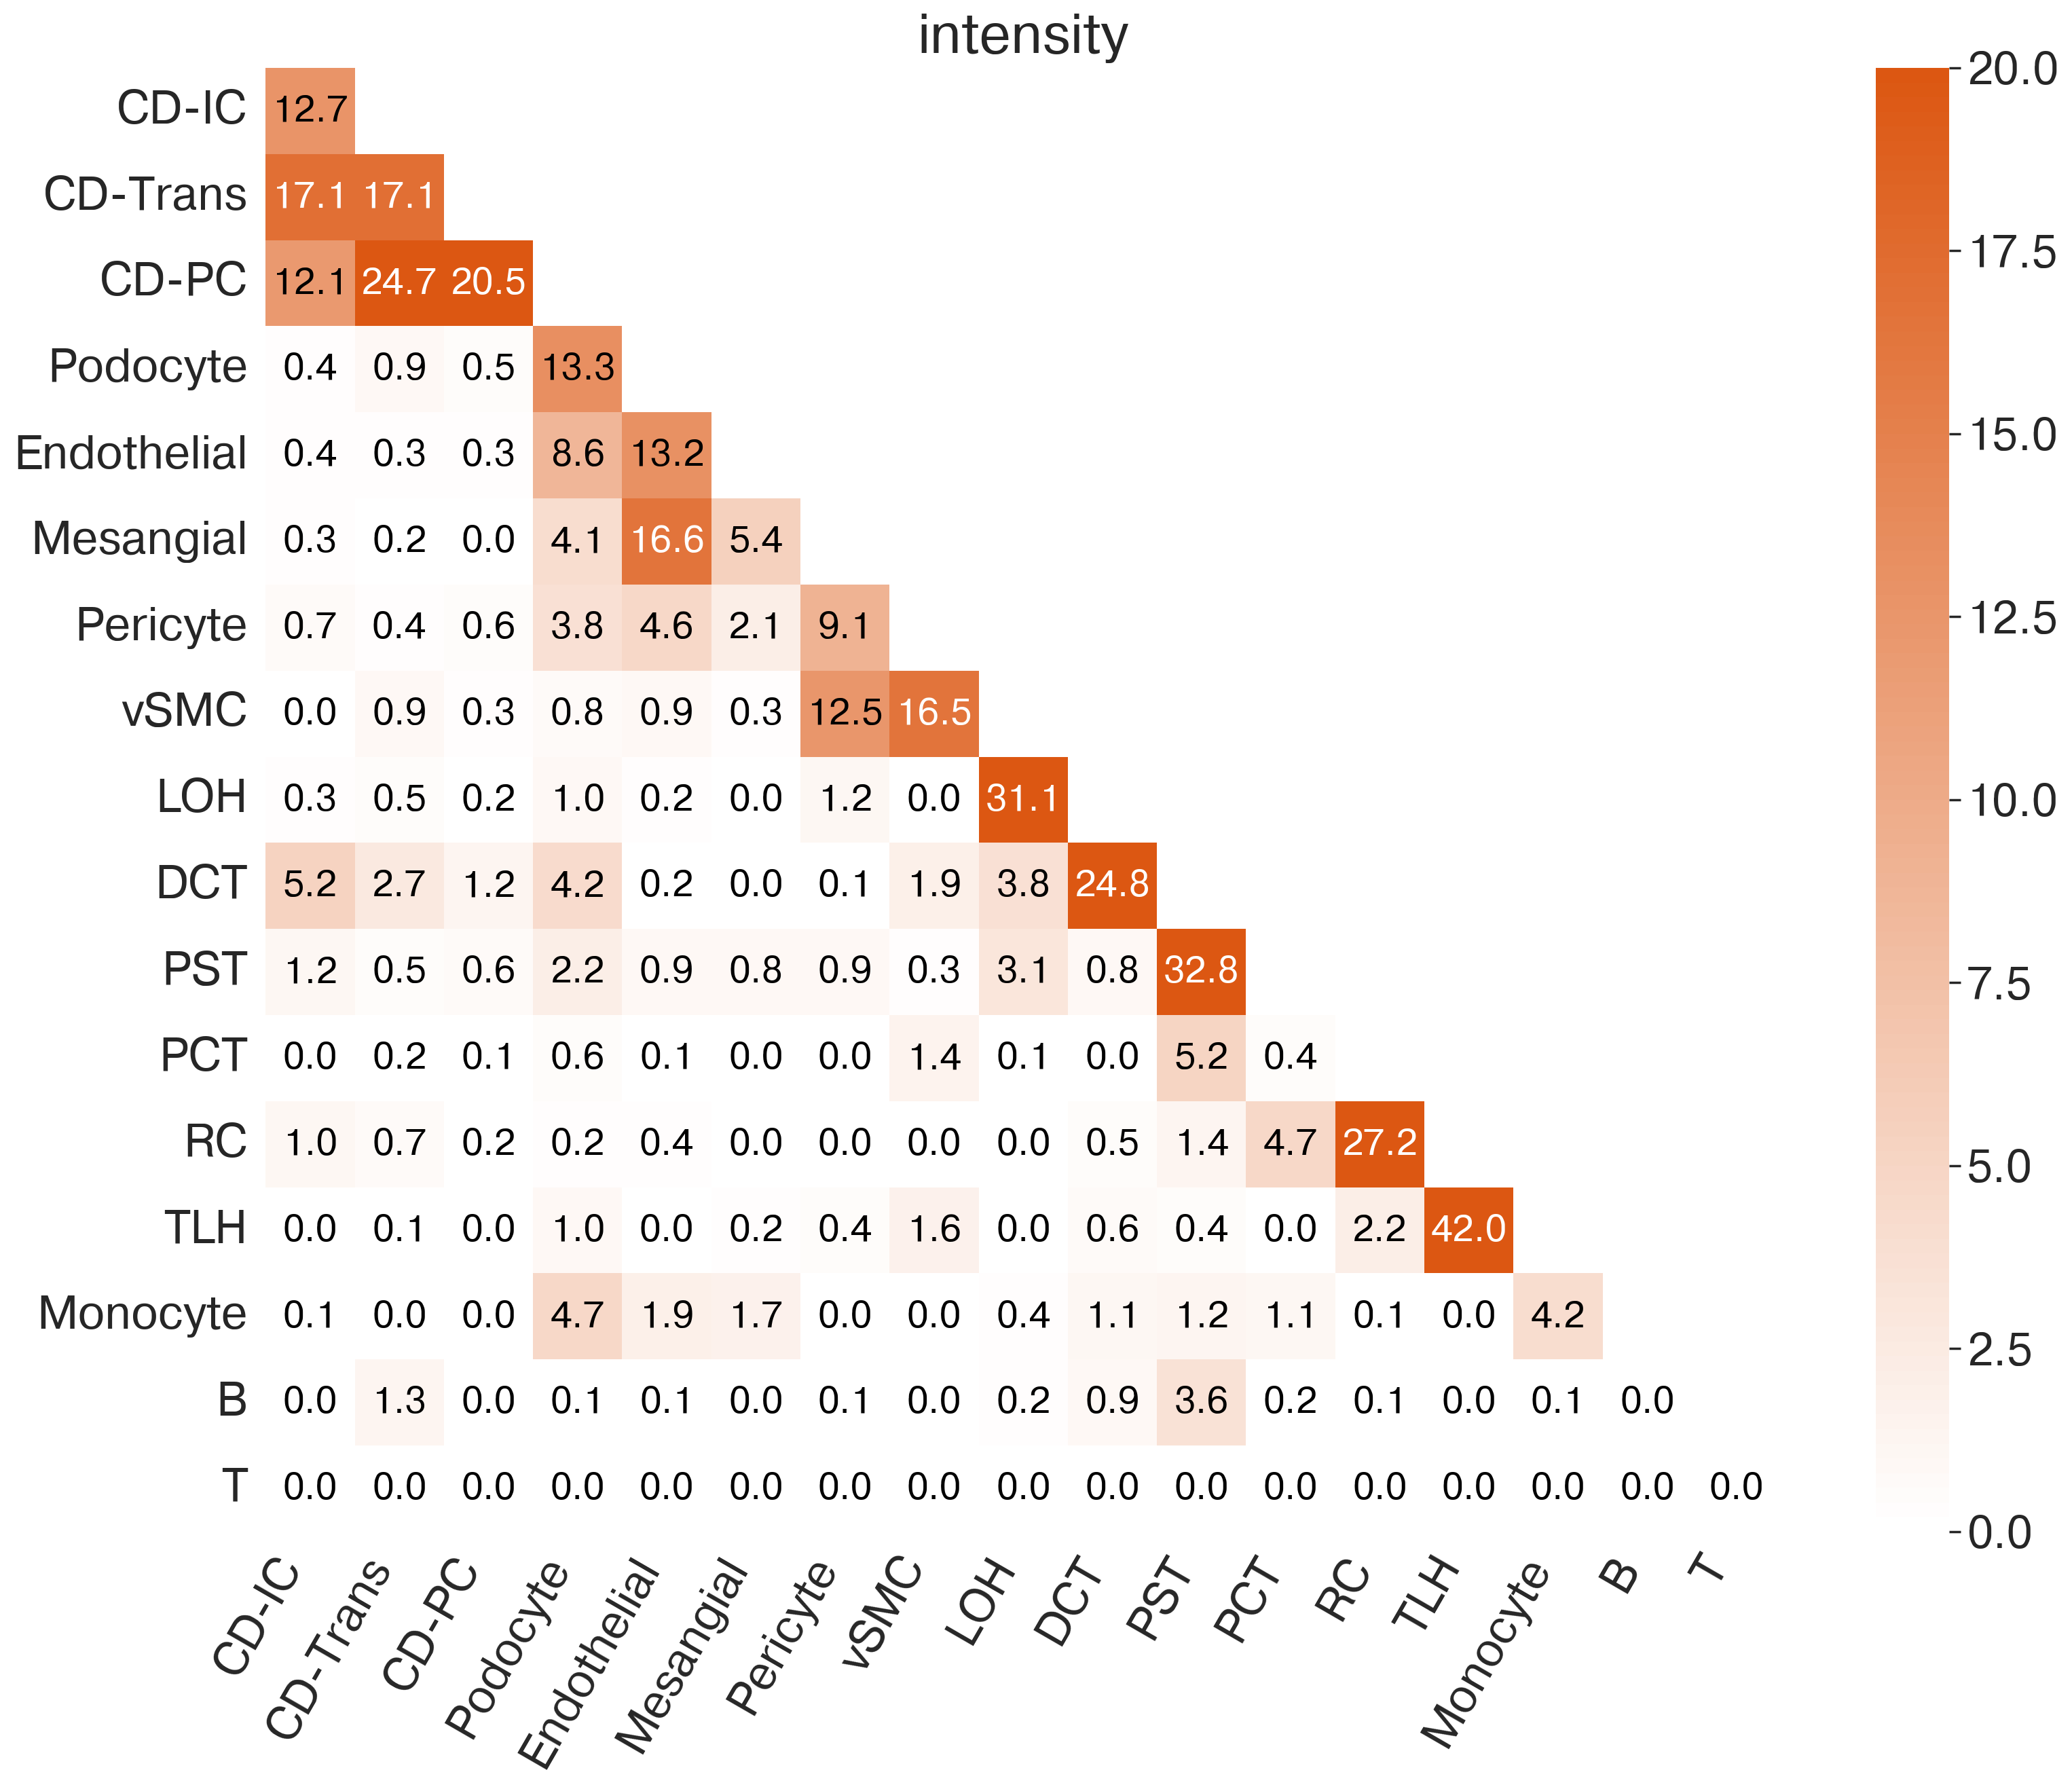

In [11]:
tmp = df.loc[df['CellID'].isin(df['CellID'].value_counts()[df['CellID'].value_counts()>1].index)]
cellcounts = tmp['celltype'].value_counts()

obs = is1.copy()
for i in obs.index:
    for j in obs.columns:
        obs.loc[i,j] = 100*obs.loc[i,j]/(cellcounts[i]*cellcounts[j])**0.5
obs = obs.fillna(0)

cmap = continue_color("#ffffff", "#dc5712", n_colors=100, show=False)
heatmapPlot(obs, 
            figsize=(18,14), 
            fmt='.1f', 
            minimum=0,
            threashold=20, 
            title='intensity',
            cmap=cmap,
            save='./figure/kidney/CellID/merge/IR_intensity.pdf')

<Figure size 10000x200 with 0 Axes>

<Figure size 1800x1400 with 0 Axes>

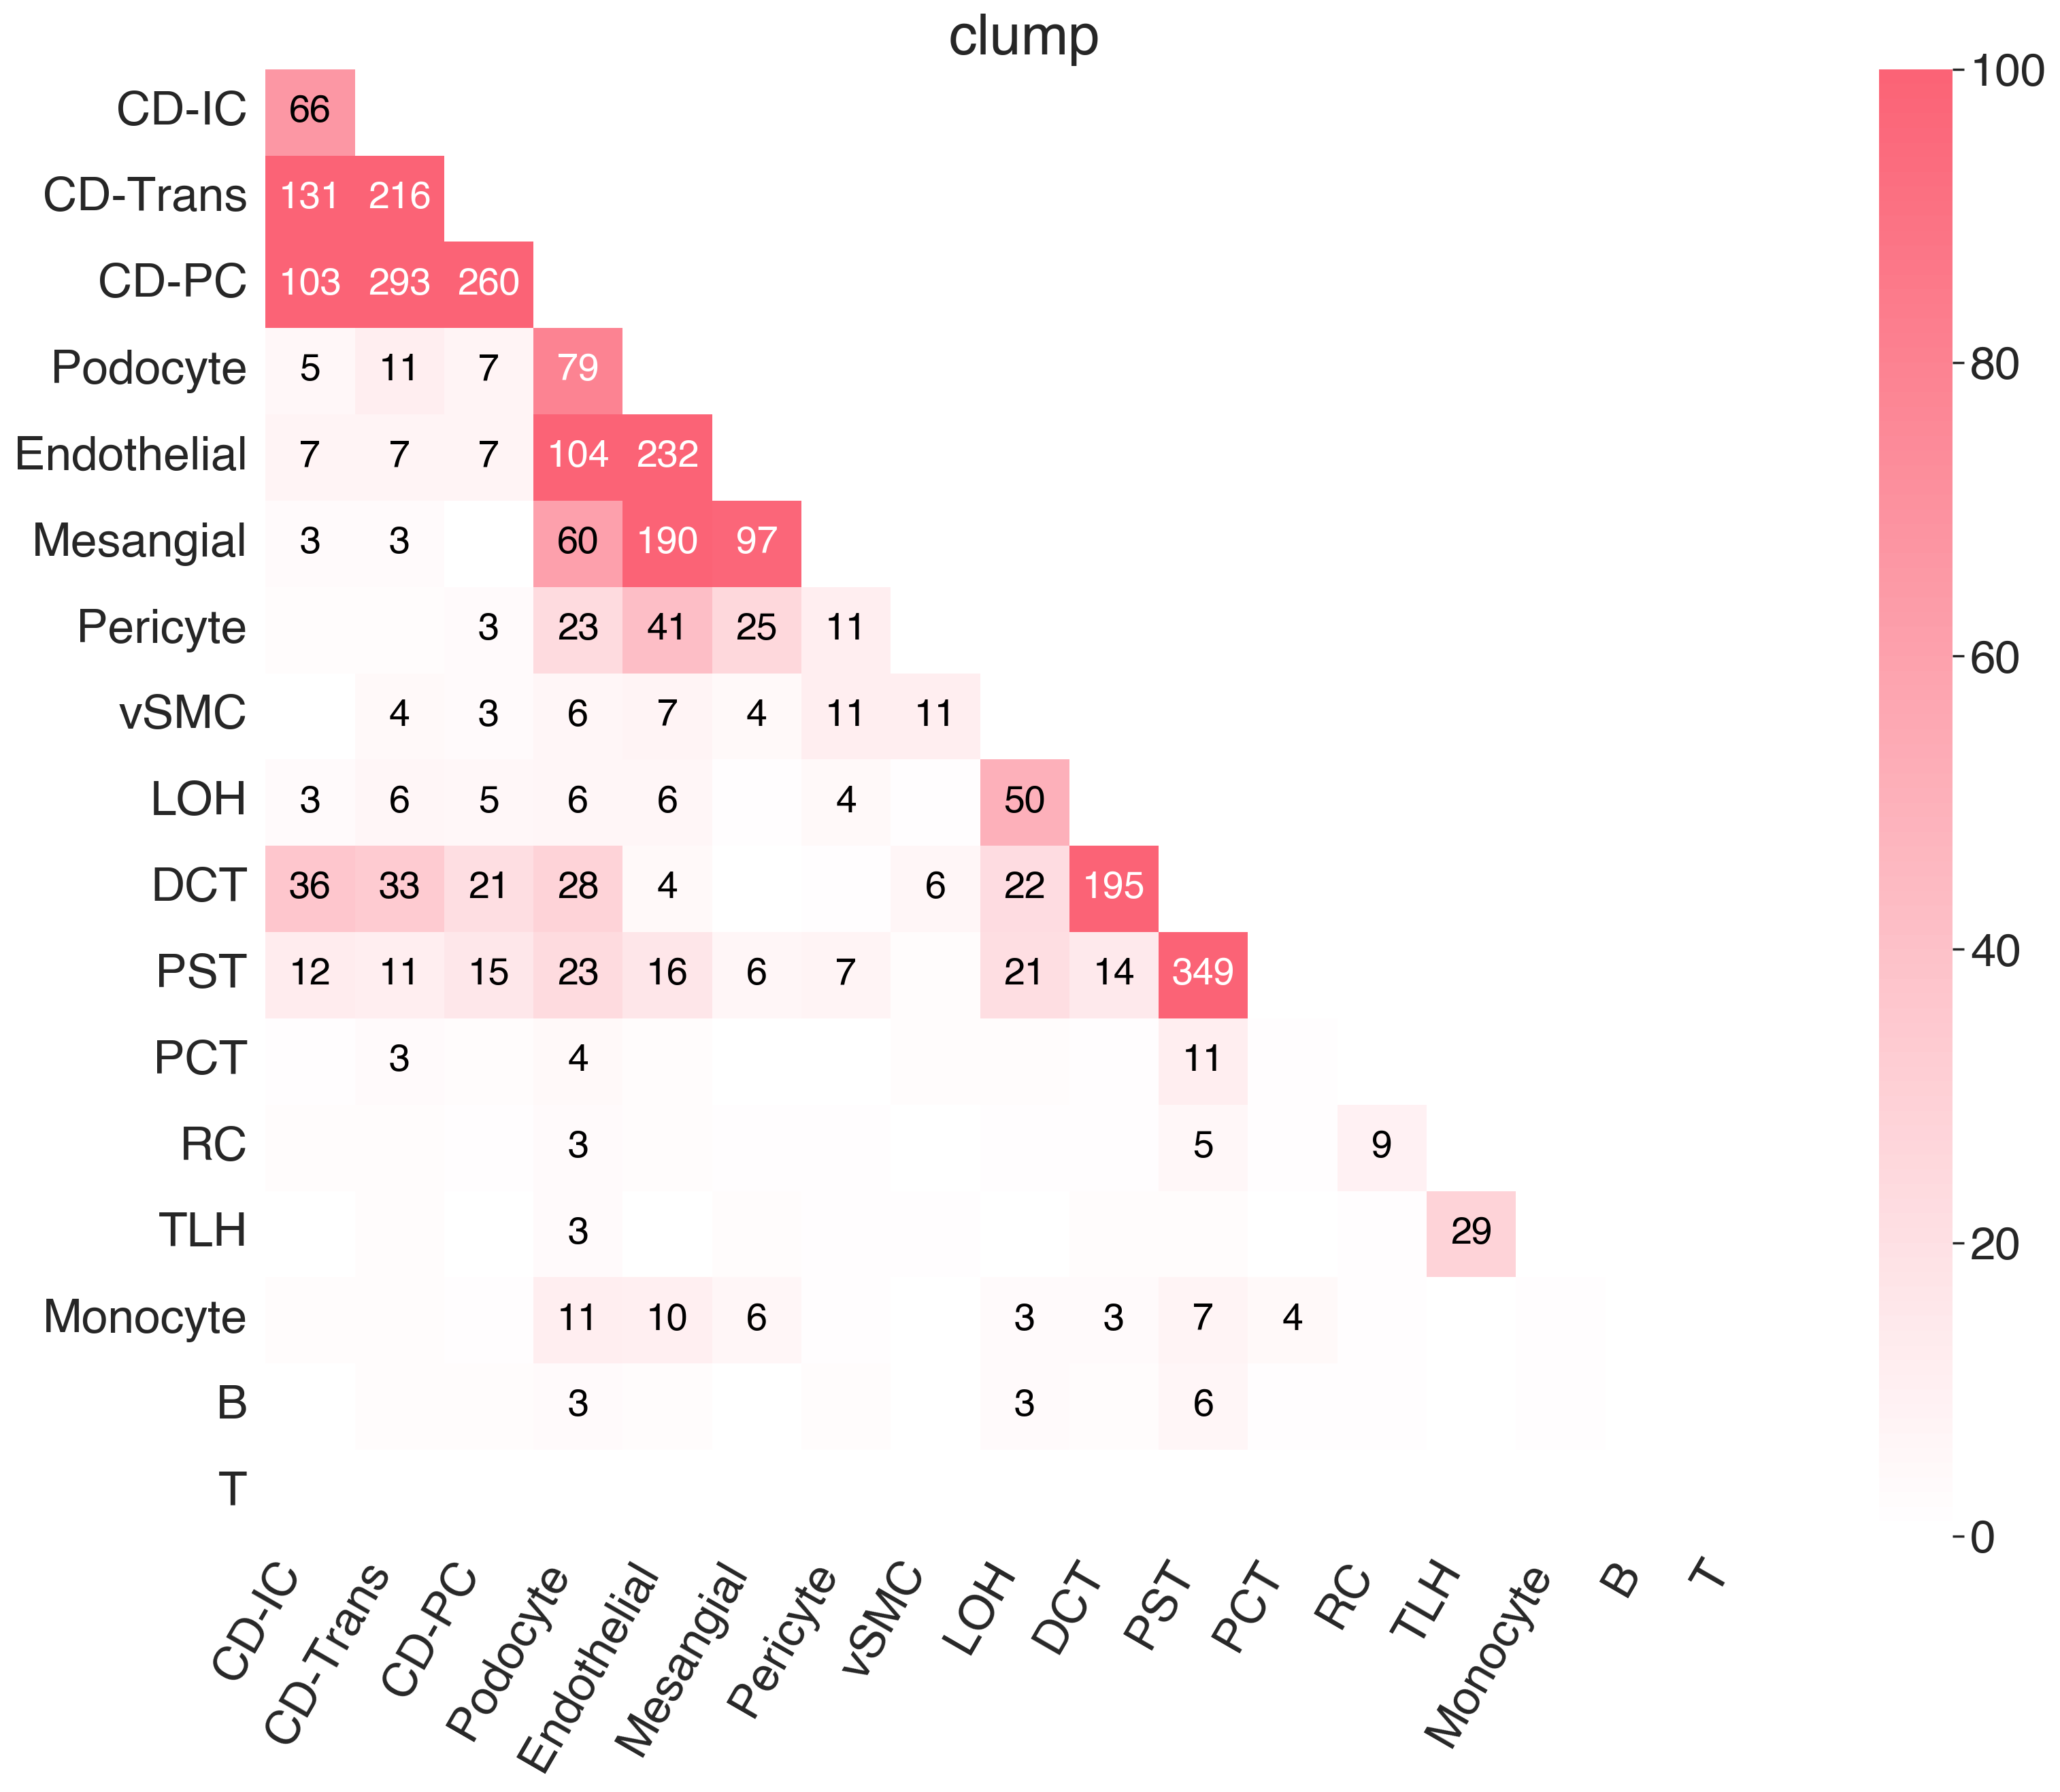

In [11]:
cmap = continue_color("#ffffff", "#FB6376", n_colors=100, show=False)
obs = is2.copy().astype(int)
heatmapPlot(obs, 
            figsize=(18,14), 
            fmt='d', 
            minimum=3,
            pvalue=obs, 
            threashold=100, 
            title='clump',
            save='./figure/kidney/CellID/merge/IR_clump.pdf')

## permutation test

In [ ]:
def heatmapPlot(data,
                ibool,
                ibool_threashold,
                pvalue,
                vmax=None,
                vmin=None,
                cmap=None,
                mask=None,
                fmt = 'd',
                figsize=(9.5,7.8),
                title='',
                save=False):
    """
    """
   
    plt.style.use('default')
    plt.rc('font', family='Helvetica')
    plt.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=figsize)
    sns.set_theme(style='white')
  
    tmp = data.copy()
    if vmax is not None:
        tmp[tmp>vmax] = vmax
    if vmin is not None:
        tmp[tmp<vmin] = vmin
    tmp = tmp*(ibool>ibool_threashold)
    
    if cmap is None:
        cmap = sns.cubehelix_palette(light=1, as_cmap=True, rot=.3, dark=0.3)

    sns.set_theme(font_scale=2.2, font='Helvetica',style='white')
    
    mask = np.triu(np.ones_like(data,dtype=bool),k=1)
    ax = sns.heatmap(tmp,
                     xticklabels=1,
                     yticklabels=1,
                     cmap=cmap,
                     mask=mask,
                     vmax=vmax,
                     vmin=vmin,
                     # square=True,
                     cbar_kws={"shrink": 1})
    plt.xticks(rotation=60, fontsize=25, ha='right') 
    plt.yticks(rotation=0, fontsize=25)
    plt.title(title, fontsize=25, pad=8)
    thresh = tmp.max().max() / 1.5
    
    import itertools
    fontsize=20
                
    for i, j in itertools.product(range(ibool.shape[0]), range(ibool.shape[1])):
        if j <= i:
            if ibool.iloc[i, j] <= ibool_threashold:
                plt.text(j+0.5, i+0.6, '#',
                     ha='center', 
                     va='bottom',
                     fontsize=fontsize,
                     color="white" if data.iloc[i, j] > thresh else "black")
            elif pvalue.iloc[i, j] < 0.05:            
                    plt.text(j+0.5, i+0.6, format(data.iloc[i, j], fmt),
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if data.iloc[i, j] > thresh else "black")
                    if pvalue.iloc[i, j]>=0.01: 
                        plt.text(j+0.5, i+1.1, '*',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
                    elif (pvalue.iloc[i, j] < 0.01)&(pvalue.iloc[i, j]>=0.001):
                        plt.text(j+0.5, i+1.1, '**',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
                    elif (pvalue.iloc[i, j] < 0.001):
                        plt.text(j+0.5, i+1.1, '***',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
                
    if save:
        plt.savefig(save,dpi=100,format='pdf',bbox_inches='tight')  

In [ ]:
def permutation_test(df, key='celltype', outdir='./'):
    import random

    tmp = df.loc[df['CellID'].isin(df['CellID'].value_counts()[df['CellID'].value_counts()>1].index)]
    cellcounts = tmp[key].value_counts()
    
    clumps_all = df.groupby('CellID')[key].apply(lambda x:list(x))
    clumps = []
    for clump in clumps_all:
        if len(clump) > 1:
            clumps.append(clump)
    clumps_merge = np.concatenate(clumps)     
    a = 0
    split_idx = [a]
    for i in range(len(clumps)):
        a = a + len(clumps[i])
        split_idx.append(a)
    
    obs_permutation_all = []
    n_permutation = 1000
    for n in range(n_permutation):
        if n%100==0:
            print(n)
        clumps_tmp = random.sample(list(clumps_merge),len(clumps_merge))
        clumps_permutation = []
        for i in range(len(split_idx)-1):
            clumps_permutation.append(list(clumps_tmp[split_idx[i]:split_idx[i+1]]))
        out = InteractionStrength(clumps_permutation, cts)
        
        for _1 in out.index:
            for _2 in out.columns:
                out.loc[_1,_2] = 100*out.loc[_1,_2]/(cellcounts[_1]*cellcounts[_2])**0.5
        
        obs_permutation_all.append(out)
    
    obs = InteractionStrength(clumps, cts)
    for _1 in obs.index:
        for _2 in obs.columns:
            obs.loc[_1,_2] = 100*obs.loc[_1,_2]/(cellcounts[_1]*cellcounts[_2])**0.5
    
    p = []
    for obs_permutation in obs_permutation_all:
        tmp = (obs < obs_permutation).astype(int)
        p.append(tmp)
    
    p = pd.DataFrame(np.sum(p, axis=0)/n_permutation, index=cts, columns=cts)
    e = pd.DataFrame(obs.values/(np.mean(obs_permutation_all, axis=0)+1e-8), index=cts, columns=cts)
    
    obs.to_csv(outdir + '/AB.txt', sep='\t')
    obs_permutation = pd.DataFrame(np.mean(obs_permutation_all, axis=0), index=cts, columns=cts)
    obs_permutation.to_csv(outdir + '/AB_permutation.txt', sep='\t')
    p.to_csv(outdir + '/AB_p.txt', sep='\t')
    e.to_csv(outdir + '/AB_e.txt', sep='\t')

In [ ]:
adata = sc.read_h5ad('./result/kidney/RNA/adata.h5ad')
df = pd.read_csv('./result/kidney/CellID/result_qc.txt', sep='\t', index_col=0)

df = df.loc[df['qc']=='1']
df['celltype'] = df['celltype'].astype('category')
cts = ['CD-IC', 'CD-Trans','CD-PC','Podocyte','Endothelial','Mesangial','Pericyte',
       'vSMC','LOH','DCT','PST','PCT','RC','TLH','Monocyte','B','T']
df['celltype'] = df['celltype'].cat.set_categories(cts)

In [ ]:
permutation_test(df, key='celltype', outdir='./result/kidney/CellID/permutation_test/')

In [ ]:
x = pd.read_csv('./result/kidney/CellID/permutation_test/AB.txt', sep='\t', index_col=0)
y = pd.read_csv('./result/kidney/CellID/permutation_test/AB_permutation.txt', sep='\t', index_col=0)
p = pd.read_csv('./result/kidney/CellID/permutation_test/AB_p.txt', sep='\t', index_col=0)  

e = x/(y+1e-8)
p_enrich = p.copy()
p_depletion = 1 - p_enrich
p = p_enrich*(e>=1).fillna(0) + p_depletion*(e<1).fillna(0)

e = np.log2(e)
e.replace([np.inf, -np.inf], 0, inplace=True)

e.columns = ['CD-IC', 'CD-Trans','CD-PC','Podocyte','Endothelial','Mesangial','Pericyte',
             'vSMC','DCT','LOH','PST','RC','PCT','TLH','Monocyte','B','T']
e.index = ['CD-IC', 'CD-Trans','CD-PC','Podocyte','Endothelial','Mesangial','Pericyte',
             'vSMC','DCT','LOH','PST','RC','PCT','TLH','Monocyte','B','T']
p.columns = ['CD-IC', 'CD-Trans','CD-PC','Podocyte','Endothelial','Mesangial','Pericyte',
             'vSMC','DCT','LOH','PST','RC','PCT','TLH','Monocyte','B','T']
p.index = ['CD-IC', 'CD-Trans','CD-PC','Podocyte','Endothelial','Mesangial','Pericyte',
             'vSMC','DCT','LOH','PST','RC','PCT','TLH','Monocyte','B','T']

cts = ['CD-IC', 'CD-Trans','CD-PC','Podocyte','Endothelial','Mesangial','Pericyte',
       'vSMC','LOH','DCT','PST','PCT','RC','TLH','Monocyte','B','T']
e = e.loc[cts, cts]
p = p.loc[cts, cts]

<Figure size 10000x200 with 0 Axes>

<Figure size 20000x200 with 0 Axes>

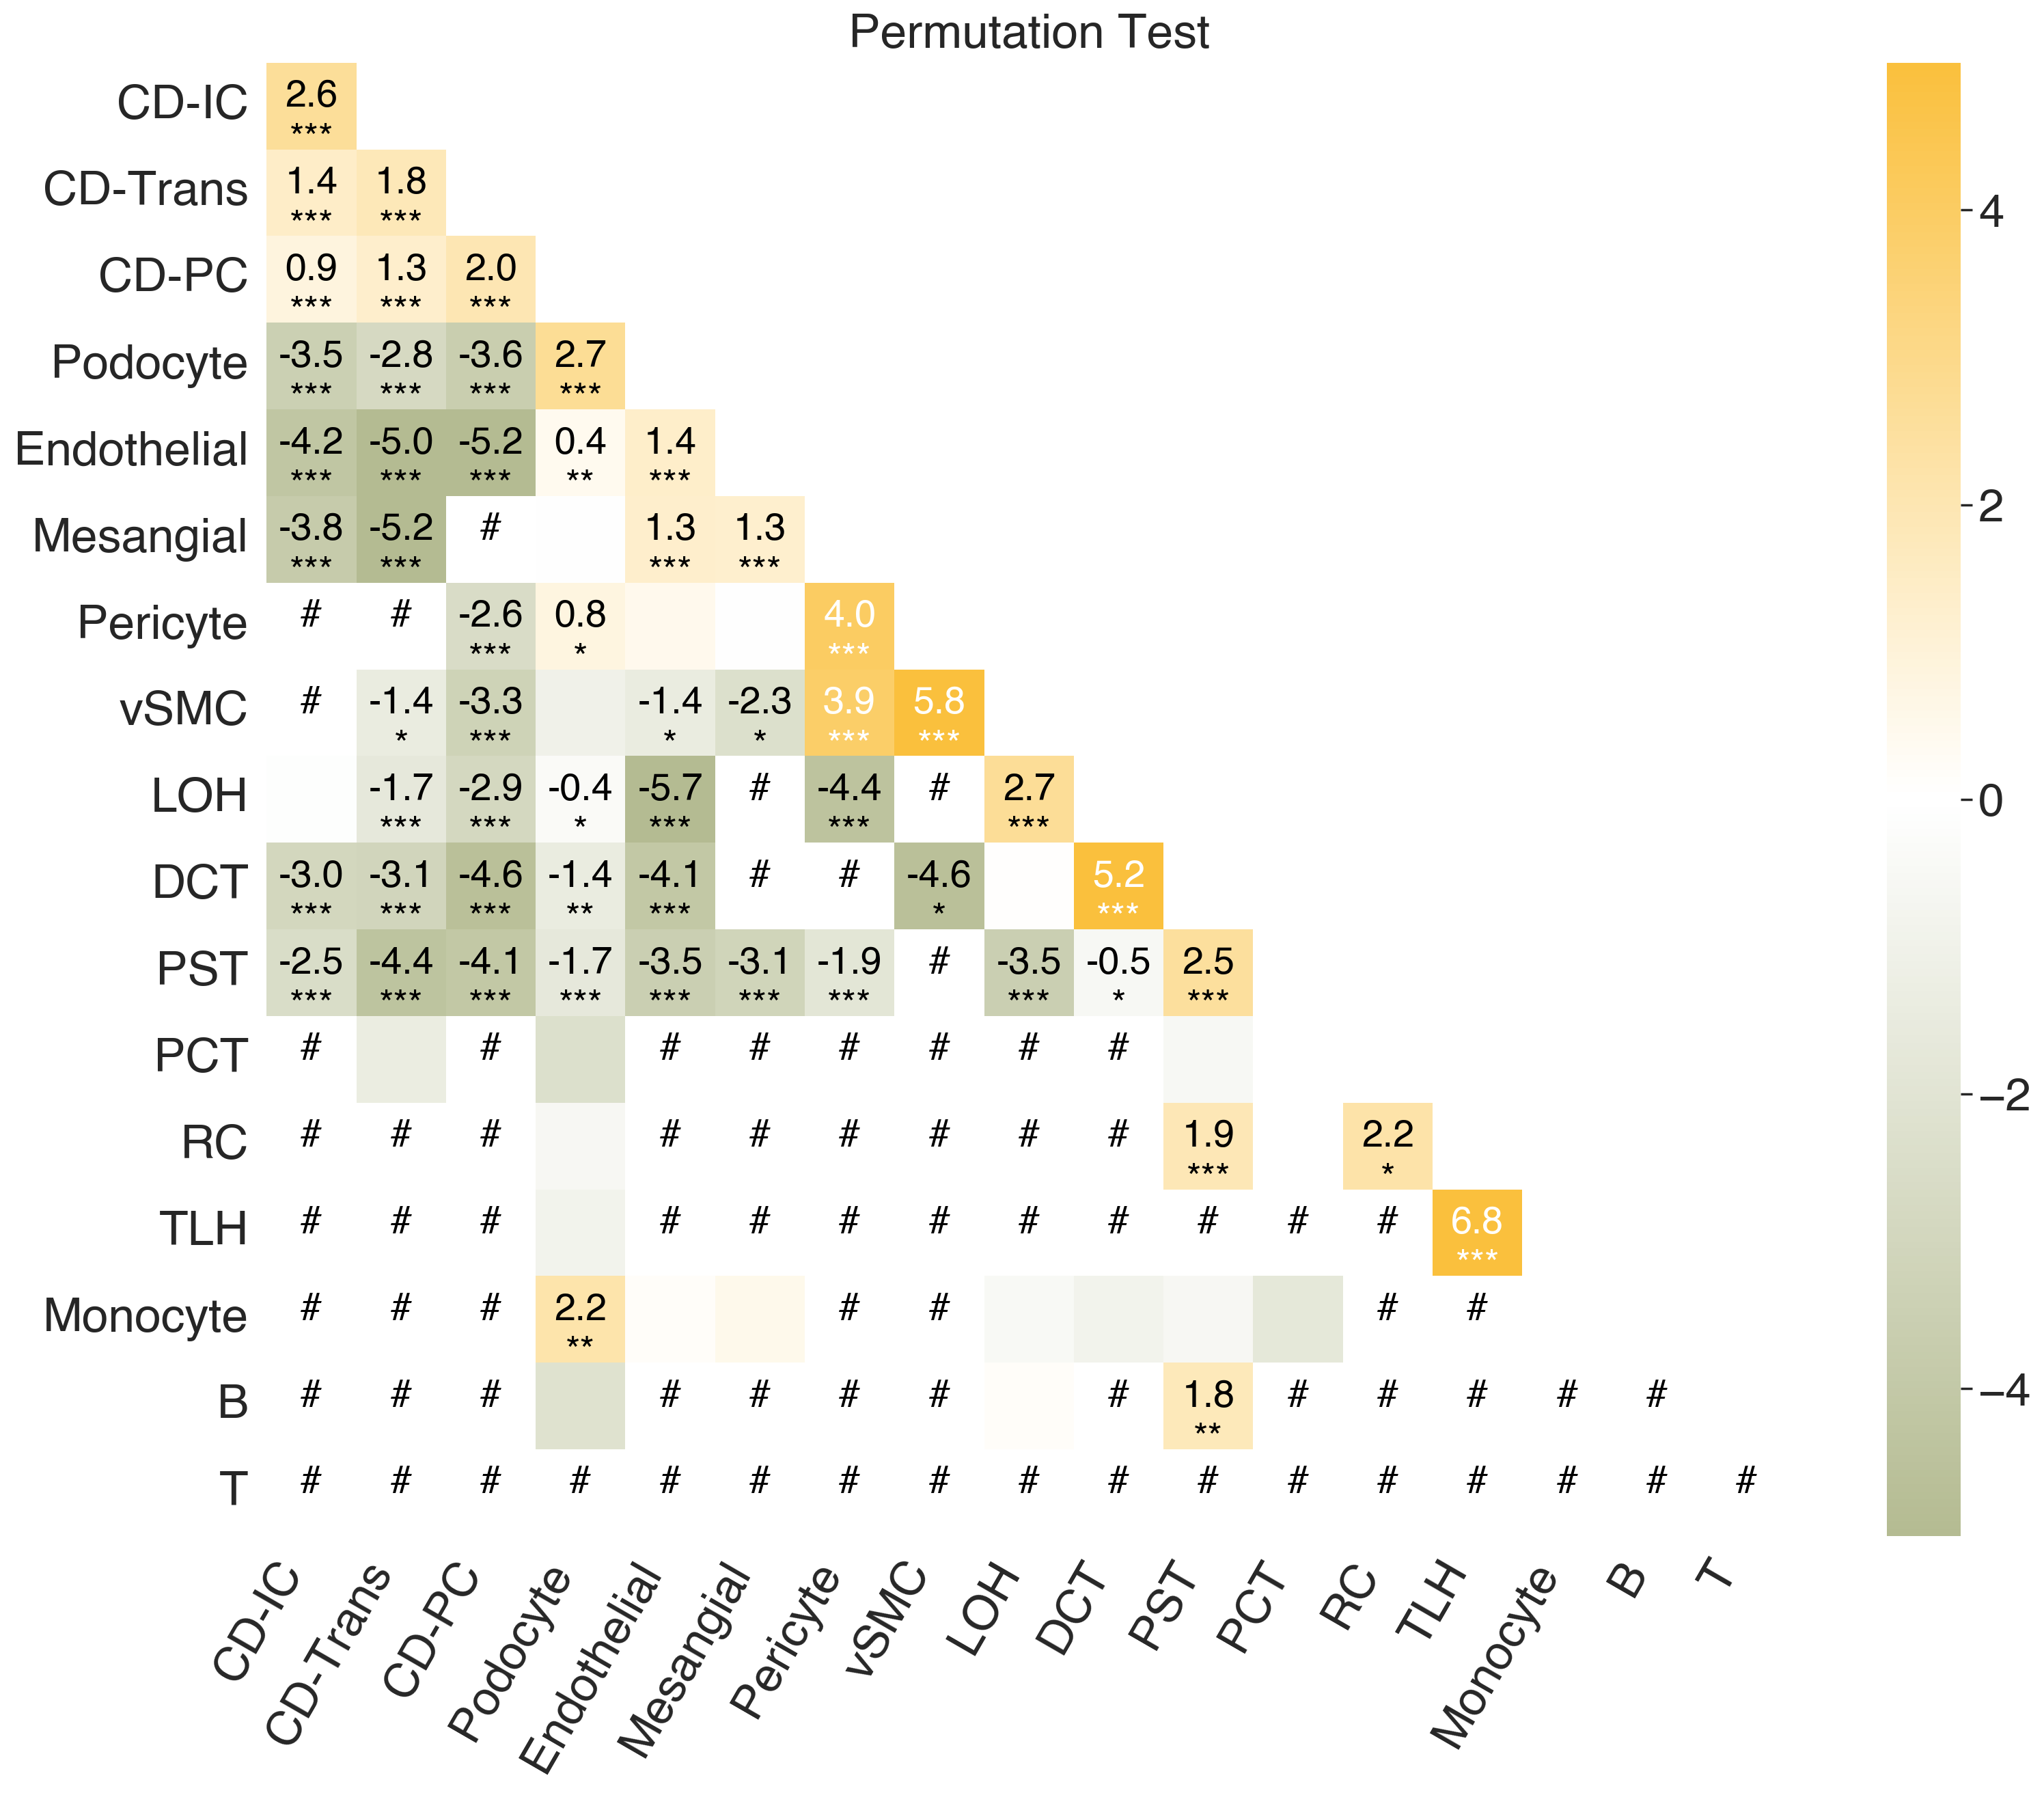

In [17]:
cmap2 = continue_color( "#ffffff",'#fac03d', n_colors=100, show=False)
cmap1 = continue_color('#697723', "#ffffff", n_colors=200, show=False)
cmap = cmap1[100:]+cmap2
heatmapPlot(e, 
            ibool=ibool,
            ibool_threashold=2,
            pvalue=p,
            vmax=5, 
            vmin=-5, 
            figsize=(18,14),
            fmt='.1f', 
            title='Permutation Test',
            cmap=cmap,
            save='./figure/kidney/CellID/merge/interaction_permutation.pdf')